In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import folium
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 고위험 자치구 분류 모델을 위한 EDA

## 1. 데이터 로드 및 기본 탐색

In [4]:
# 데이터 로드
# 범죄 데이터
crime_data = pd.read_excel('../../dataset/범죄안전데이터/112 신고출동 현황/23년상반기.xlsx')

# CCTV 데이터
cctv_data = pd.read_excel('../../dataset/위치 데이터/cctv데이터.xlsx')

# 인구 데이터
population_data = pd.read_excel('../../dataset/인구데이터/등록인구_20250412000902.xlsx')

# 데이터 기본 정보 출력
print("=== 범죄 데이터 ===")
print(crime_data.head())
print("\n컬럼:", crime_data.columns.tolist())
print("\n결측치:", crime_data.isnull().sum())

print("\n=== CCTV 데이터 ===")
print(cctv_data.head())
print("\n컬럼:", cctv_data.columns.tolist())
print("\n결측치:", cctv_data.isnull().sum())

print("\n=== 인구 데이터 ===")
print(population_data.head())
print("\n컬럼:", population_data.columns.tolist())
print("\n결측치:", population_data.isnull().sum())

=== 범죄 데이터 ===
  2023년 1월~6월 경찰서별 신고 건수 Unnamed: 1 Unnamed: 2
0                    경찰서         긴급        비긴급
1                  서울중부서       7451      14883
2                  서울종로서       7068      17208
3                 서울남대문서       4171      12082
4                 서울서대문서      10578      21813

컬럼: ['2023년 1월~6월 경찰서별 신고 건수', 'Unnamed: 1', 'Unnamed: 2']

결측치: 2023년 1월~6월 경찰서별 신고 건수    0
Unnamed: 1                0
Unnamed: 2                0
dtype: int64

=== CCTV 데이터 ===
   번호       관리기관명              소재지도로명주소           소재지지번주소 설치목적구분  카메라대수  \
0   1  서울특별시 성동구청          서울특별시 마조로 11   서울특별시 행당동 19-98   교통단속      3   
1   2  서울특별시 성동구청  서울특별시 고산자로 330 (마장동)  서울특별시 마장동 520-10   교통단속      2   
2   3  서울특별시 성동구청       서울특별시 마장로35길 76     서울특별시 마장동 818   교통단속      3   
3   4  서울특별시 성동구청   서울특별시 마장로 325 (마장동)  서울특별시 마장동 767-41   교통단속      3   
4   5  서울특별시 성동구청   서울특별시 마장로 322 (마장동)   서울특별시 마장동 781-1   교통단속      2   

   카메라화소수   촬영방면정보  보관일수     설치연월      관리기관전화번호    WGS84위도     WGS84경도 

# 데이터 전처리

### 1. 범죄 데이터 전처리

In [21]:
crime_data = pd.read_excel('../../dataset/범죄안전데이터/112 신고출동 현황/23년상반기.xlsx', header=1)
crime_data.columns = ['경찰서', '긴급', '비긴급']

print(crime_data.head())

      경찰서     긴급    비긴급
0   서울중부서   7451  14883
1   서울종로서   7068  17208
2  서울남대문서   4171  12082
3  서울서대문서  10578  21813
4   서울혜화서   5322  11054


In [22]:
# 경찰서 이름 전처리
crime_data['경찰서'] = crime_data['경찰서'].str.replace('서울', '').str.replace('서', '')

print(crime_data['경찰서'].unique())

['중부' '종로' '남대문' '대문' '혜화' '용산' '성북' '동대문' '마포' '영등포' '성동' '동작' '광진' '부'
 '강북' '금천' '중랑' '강남' '관악' '강' '강동' '종암' '구로' '초' '양천' '송파' '노원' '방배' '은평'
 '도봉' '수']


In [23]:
# 구 매핑 딕셔너리
gu_mapping = {
    '중부': '중구',
    '종로': '종로구',
    '남대문': '중구',
    '서대문': '서대문구',
    '혜화': '종로구',
    '강남': '강남구',
    '강동': '강동구',
    '강서': '강서구',
    '관악': '관악구',
    '광진': '광진구',
    '구로': '구로구',
    '금천': '금천구',
    '노원': '노원구',
    '도봉': '도봉구',
    '동대문': '동대문구',
    '동작': '동작구',
    '마포': '마포구',
    '방배': '서초구',
    '서초': '서초구',
    '성동': '성동구',
    '성북': '성북구',
    '송파': '송파구',
    '수서': '강남구',
    '양천': '양천구',
    '영등포': '영등포구',
    '용산': '용산구',
    '은평': '은평구',
    '잠실': '송파구',
    '종암': '성북구',
    '중랑': '중랑구'
}

crime_data['구'] = crime_data['경찰서'].map(gu_mapping)

print(crime_data['구'].unique())

['중구' '종로구' nan '용산구' '성북구' '동대문구' '마포구' '영등포구' '성동구' '동작구' '광진구' '금천구'
 '중랑구' '강남구' '관악구' '강동구' '구로구' '양천구' '송파구' '노원구' '서초구' '은평구' '도봉구']


In [24]:
# 구별 범죄 데이터 집계
crime_by_gu = crime_data.groupby('구').agg({
    '긴급': 'sum',
    '비긴급': 'sum'
}).reset_index()

print(crime_by_gu.head())

     구     긴급    비긴급
0  강남구  19656  39404
1  강동구  16910  28269
2  관악구  21888  38528
3  광진구  15288  28311
4  구로구  16093  26204


### 2. CCTV 데이터 전처리

In [26]:
cctv_data['소재지도로명주소'] = cctv_data['소재지도로명주소'].astype(str)
cctv_data['구'] = cctv_data['소재지도로명주소'].str.split(' ').str[1]
cctv_count_by_gu = cctv_data.groupby('구')['카메라대수'].sum().reset_index()

print(cctv_count_by_gu.head())

       구  카메라대수
0             5
1  (둔촌동)      3
2  (상일동)      3
3  (암사동)      4
4      -     15


### 3. 인구 데이터 전처리

In [31]:
population_data = pd.read_excel('../../dataset/인구데이터/등록인구_20250412000902.xlsx', skiprows=2)
population_data.columns = ['구1', '구2', '세대수', '총인구', '남자인구', '여자인구', 
                         '한국인_총', '한국인_남', '한국인_여', '외국인_총', '외국인_남', '외국인_여',
                         '세대당인구', '고령자수']

print(population_data.head())


    구1   구2      세대수      총인구     남자인구     여자인구    한국인_총    한국인_남    한국인_여  \
0   합계   소계  4482063  9597372  4619963  4977409  9331828  4505355  4826473   
1  NaN  종로구    72166   149608    71365    78243   138336    66570    71766   
2  NaN   중구    64995   131214    62924    68290   120544    58015    62529   
3  NaN  용산구   103241   217194   104540   112654   203854    97469   106385   
4  NaN  성동구   131953   281289   135575   145714   273669   132409   141260   

    외국인_총   외국인_남   외국인_여  세대당인구     고령자수  
0  265544  114608  150936   2.08  1824895  
1   11272    4795    6477   1.92    29840  
2   10670    4909    5761   1.85    26853  
3   13340    7071    6269   1.97    39407  
4    7620    3166    4454   2.07    51245  


In [32]:
# 구 데이터만 선택
population_data = population_data[population_data['구1'].isna()].copy()
population_data = population_data.drop('구1', axis=1)
population_data = population_data.rename(columns={'구2': '구'})

print(population_data.head())

     구     세대수     총인구    남자인구    여자인구   한국인_총   한국인_남   한국인_여  외국인_총  외국인_남  \
1  종로구   72166  149608   71365   78243  138336   66570   71766  11272   4795   
2   중구   64995  131214   62924   68290  120544   58015   62529  10670   4909   
3  용산구  103241  217194  104540  112654  203854   97469  106385  13340   7071   
4  성동구  131953  281289  135575  145714  273669  132409  141260   7620   3166   
5  광진구  169931  348652  166045  182607  331963  159237  172726  16689   6808   

   외국인_여  세대당인구   고령자수  
1   6477   1.92  29840  
2   5761   1.85  26853  
3   6269   1.97  39407  
4   4454   2.07  51245  
5   9881   1.95  59743  


In [33]:
# 최종 데이터 확인
print("=== 전처리된 범죄 데이터 ===")
print(crime_by_gu)
print("\n=== 구별 CCTV 수 ===")
print(cctv_count_by_gu)
print("\n=== 전처리된 인구 데이터 ===")
print(population_data)

# 데이터 품질 확인
print("\n=== 데이터 품질 확인 ===")
print("범죄 데이터 구 목록:", sorted(list(crime_by_gu['구'].dropna().unique())))
print("CCTV 데이터 구 목록:", sorted(list(cctv_count_by_gu['구'].dropna().unique())))
print("인구 데이터 구 목록:", sorted(list(population_data['구'].dropna().unique())))

=== 전처리된 범죄 데이터 ===
       구     긴급    비긴급
0    강남구  19656  39404
1    강동구  16910  28269
2    관악구  21888  38528
3    광진구  15288  28311
4    구로구  16093  26204
5    금천구  11763  19423
6    노원구  16798  28884
7    도봉구  10536  18090
8   동대문구  14930  28294
9    동작구  13924  22450
10   마포구  20239  36870
11   서초구   4885   8280
12   성동구  11453  21353
13   성북구  13647  24845
14   송파구  23986  41957
15   양천구  12533  23661
16  영등포구  22731  39223
17   용산구  13594  25280
18   은평구   7782  14277
19   종로구  12390  28262
20    중구  11622  26965
21   중랑구  15343  27095

=== 구별 CCTV 수 ===
            구  카메라대수
0                  5
1       (둔촌동)      3
2       (상일동)      3
3       (암사동)      4
4           -     15
...       ...    ...
1706  희우정로16길      1
1707  희우정로17길      1
1708   희우정로1길      5
1709  희우정로20길      4
1710  희우정로21길      4

[1711 rows x 2 columns]

=== 전처리된 인구 데이터 ===
       구     세대수     총인구    남자인구    여자인구   한국인_총   한국인_남   한국인_여  외국인_총  \
1    종로구   72166  149608   71365   78243  138336   66570   

In [ ]:
# 구 이름 일치 여부 확인
all_gu_names = set(crime_by_gu['구'].dropna()) | set(cctv_count_by_gu['구'].dropna()) | set(population_data['구'].dropna())
print("\n=== 전체 구 목록 ===")
print(sorted(list(all_gu_names)))

# 데이터 불일치 확인
print("\n=== 데이터 불일치 확인 ===")
for gu in all_gu_names:
    in_crime = gu in crime_by_gu['구'].values
    in_cctv = gu in cctv_count_by_gu['구'].values
    in_pop = gu in population_data['구'].values
    if not (in_crime and in_cctv and in_pop):
        print(f"{gu}: 범죄데이터({in_crime}), CCTV데이터({in_cctv}), 인구데이터({in_pop})")

In [13]:


# 구 이름 일치 여부 확인
all_gu_names = set(crime_by_gu['구'].dropna()) | set(cctv_count_by_gu['구'].dropna()) | set(population_data['구'].dropna())
print("\n=== 전체 구 목록 ===")
print(sorted(list(all_gu_names)))

# 데이터 불일치 확인
print("\n=== 데이터 불일치 확인 ===")
for gu in all_gu_names:
    in_crime = gu in crime_by_gu['구'].values
    in_cctv = gu in cctv_count_by_gu['구'].values
    in_pop = gu in population_data['구'].values
    if not (in_crime and in_cctv and in_pop):
        print(f"{gu}: 범죄데이터({in_crime}), CCTV데이터({in_cctv}), 인구데이터({in_pop})")

=== 전처리된 범죄 데이터 ===
       구     긴급    비긴급
0    강남구  19656  39404
1    강동구  16910  28269
2    관악구  21888  38528
3    광진구  15288  28311
4    구로구  16093  26204
5    금천구  11763  19423
6    노원구  16798  28884
7    도봉구  10536  18090
8   동대문구  14930  28294
9    동작구  13924  22450
10   마포구  20239  36870
11   서초구   4885   8280
12   성동구  11453  21353
13   성북구  13647  24845
14   송파구  23986  41957
15   양천구  12533  23661
16  영등포구  22731  39223
17   용산구  13594  25280
18   은평구   7782  14277
19   종로구  12390  28262
20    중구  11622  26965
21   중랑구  15343  27095

=== 구별 CCTV 수 ===
            구  카메라대수
0                  5
1       (둔촌동)      3
2       (상일동)      3
3       (암사동)      4
4           -     15
...       ...    ...
1706  희우정로16길      1
1707  희우정로17길      1
1708   희우정로1길      5
1709  희우정로20길      4
1710  희우정로21길      4

[1711 rows x 2 columns]

=== 전처리된 인구 데이터 ===
       구     세대수     총인구    남자인구    여자인구   한국인_총   한국인_남   한국인_여  외국인_총  \
1    종로구   72166  149608   71365   78243  138336   66570   

In [16]:
# 위험지수 생성

# 1. 범죄 관련 지표 계산
crime_by_gu = crime_data.groupby('구').agg({
    '긴급': 'sum',
    '비긴급': 'sum'
}).reset_index()

crime_by_gu['총신고건수'] = crime_by_gu['긴급'] + crime_by_gu['비긴급']

# 2. 데이터 병합
merged_data = pd.merge(population_data, crime_by_gu, on='구', how='left')
merged_data = pd.merge(merged_data, cctv_count_by_gu, on='구', how='left')

# 3. 인구 대비 지표 계산
merged_data['인구당범죄'] = merged_data['총신고건수'] / merged_data['총인구'] * 1000
merged_data['인구당CCTV'] = merged_data['카메라대수'] / merged_data['총인구'] * 1000
merged_data['여성인구비율'] = merged_data['여자인구'] / merged_data['총인구'] * 100
merged_data['고령자비율'] = merged_data['고령자수'] / merged_data['총인구'] * 100

# 4. 위험지수 계산 (Z-score 방식)
risk_factors = ['인구당범죄', '인구당CCTV', '여성인구비율', '고령자비율']
for factor in risk_factors:
    merged_data[f'{factor}_Z'] = (merged_data[factor] - merged_data[factor].mean()) / merged_data[factor].std()

# 종합 위험지수 계산
merged_data['위험지수'] = (
    merged_data['인구당범죄_Z'] * 0.4 +
    merged_data['인구당CCTV_Z'] * 0.2 +
    merged_data['여성인구비율_Z'] * 0.2 +
    merged_data['고령자비율_Z'] * 0.2
)

# 고위험 지역 분류 (위험지수가 평균 이상이면 1, 아니면 0)
merged_data['고위험구역'] = (merged_data['위험지수'] > merged_data['위험지수'].mean()).astype(int)

# 결과 확인
print("=== 위험지수 계산 결과 ===")
print(merged_data[['구', '위험지수', '고위험구역'] + risk_factors].sort_values('위험지수', ascending=False))

=== 위험지수 계산 결과 ===
       구      위험지수  고위험구역       인구당범죄    인구당CCTV     여성인구비율      고령자비율
1     중구  1.540617      1  294.076852  22.825308  52.044751  20.465042
0    종로구  1.223641      1  271.723437  15.634191  52.298674  19.945457
2    용산구  0.699204      1  178.982845  29.637099  51.867915  18.143687
14   양천구  0.128913      1   83.328921  35.625565  51.292848  18.508073
13   마포구  0.018816      1  153.211981   0.005366  53.747200  16.099210
6    중랑구 -0.008675      1  110.128740  11.475312  51.236412  21.666593
5   동대문구 -0.084359      0  120.534407   9.609512  51.757236  19.403630
18  영등포구 -0.132666      0  155.987441  11.826081  50.937249  17.739121
7    성북구 -0.149807      0   88.479830  10.229015  52.430483  19.209401
11   은평구 -0.175140      0   47.403030  10.424412  52.725046  21.072956
10   노원구 -0.189541      0   91.998421   6.265205  52.143582  20.255482
16   구로구 -0.281199      0  102.683557  11.327552  50.788510  20.361676
4    광진구 -0.285132      0  125.050193   3.398805  52.37514

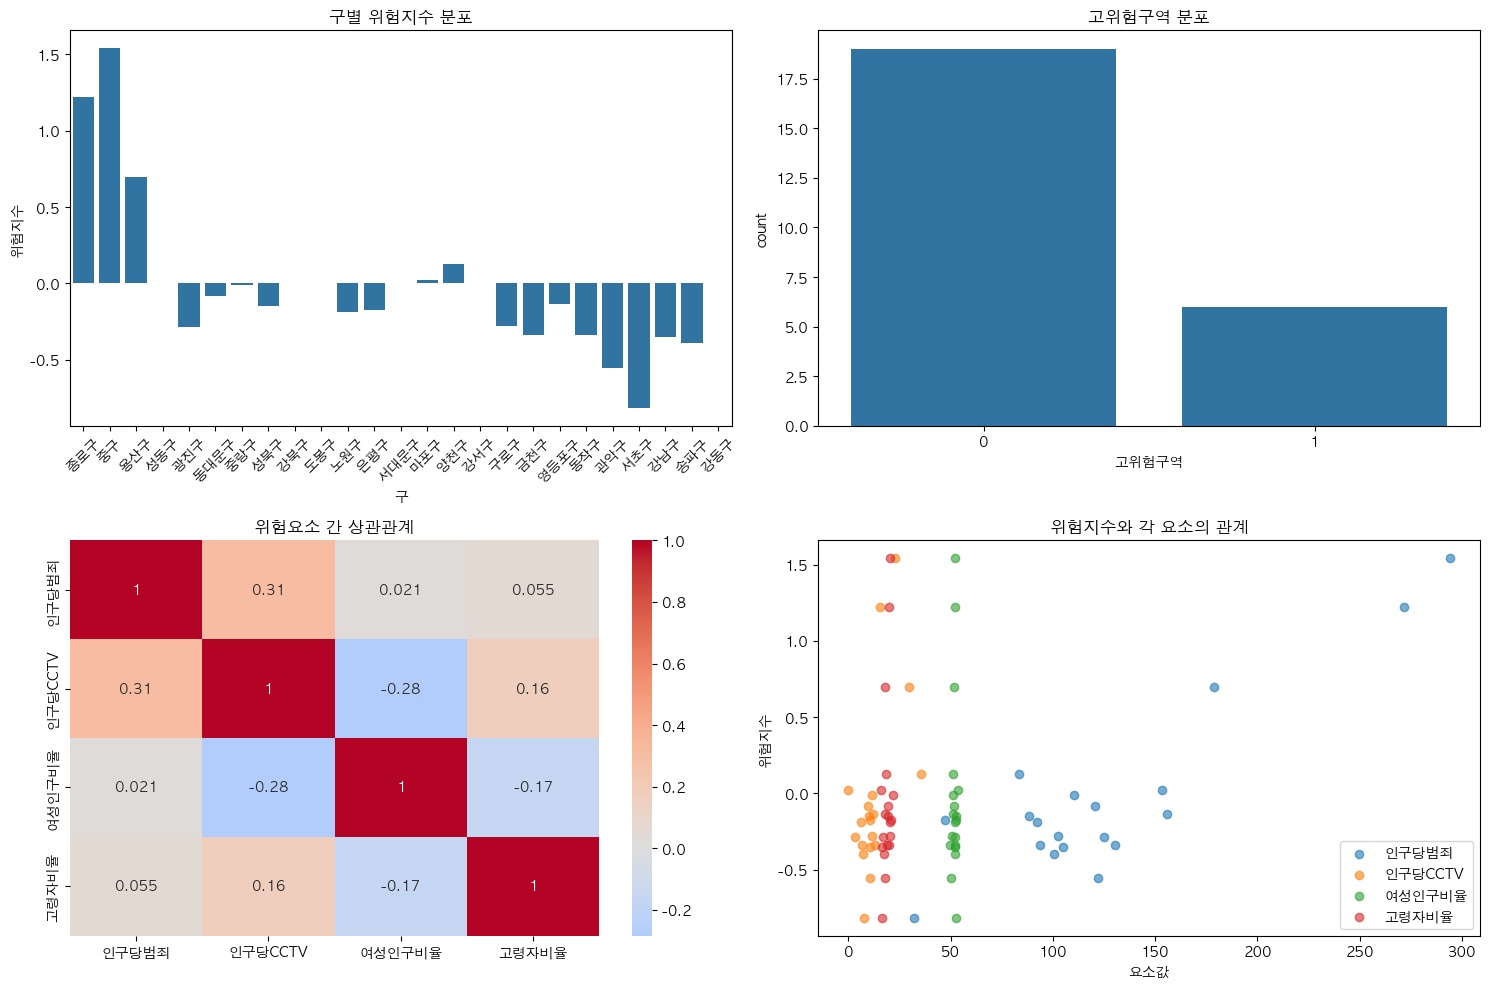


=== 구별 위험도 순위 ===
       구      위험지수  고위험구역
1     중구  1.540617      1
0    종로구  1.223641      1
2    용산구  0.699204      1
14   양천구  0.128913      1
13   마포구  0.018816      1
6    중랑구 -0.008675      1
5   동대문구 -0.084359      0
18  영등포구 -0.132666      0
7    성북구 -0.149807      0
11   은평구 -0.175140      0
10   노원구 -0.189541      0
16   구로구 -0.281199      0
4    광진구 -0.285132      0
19   동작구 -0.339670      0
17   금천구 -0.341718      0
22   강남구 -0.353836      0
23   송파구 -0.394468      0
20   관악구 -0.555161      0
21   서초구 -0.815484      0
3    성동구       NaN      0
8    강북구       NaN      0
9    도봉구       NaN      0
12  서대문구       NaN      0
15   강서구       NaN      0
24   강동구       NaN      0

=== 고위험 구역 특성 ===

인구당범죄 평균:
고위험 구역: 181.91
저위험 구역: 101.22

인구당CCTV 평균:
고위험 구역: 19.20
저위험 구역: 9.33

여성인구비율 평균:
고위험 구역: 52.08
저위험 구역: 51.79

고령자비율 평균:
고위험 구역: 19.14
저위험 구역: 19.27


In [17]:
plt.figure(figsize=(15, 10))

# 1. 위험지수 분포
plt.subplot(2, 2, 1)
sns.barplot(data=merged_data, x='구', y='위험지수')
plt.xticks(rotation=45)
plt.title('구별 위험지수 분포')

# 2. 고위험구역 분포
plt.subplot(2, 2, 2)
sns.countplot(data=merged_data, x='고위험구역')
plt.title('고위험구역 분포')

# 3. 위험요소별 상관관계
plt.subplot(2, 2, 3)
correlation_matrix = merged_data[risk_factors].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('위험요소 간 상관관계')

# 4. 위험지수와 각 요소의 산점도
plt.subplot(2, 2, 4)
for factor in risk_factors:
    plt.scatter(merged_data[factor], merged_data['위험지수'], label=factor, alpha=0.6)
plt.xlabel('요소값')
plt.ylabel('위험지수')
plt.legend()
plt.title('위험지수와 각 요소의 관계')

plt.tight_layout()
plt.show()

# 구별 위험도 순위
print("\n=== 구별 위험도 순위 ===")
risk_ranking = merged_data[['구', '위험지수', '고위험구역']].sort_values('위험지수', ascending=False)
print(risk_ranking)

# 고위험 구역 특성 분석
print("\n=== 고위험 구역 특성 ===")
high_risk = merged_data[merged_data['고위험구역'] == 1]
low_risk = merged_data[merged_data['고위험구역'] == 0]

for factor in risk_factors:
    print(f"\n{factor} 평균:")
    print(f"고위험 구역: {high_risk[factor].mean():.2f}")
    print(f"저위험 구역: {low_risk[factor].mean():.2f}")

# 지도 시각화


=== 모델링 데이터 준비 ===

=== 모델 성능 평가 ===

Confusion Matrix:
[[4 0]
 [0 1]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         1

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



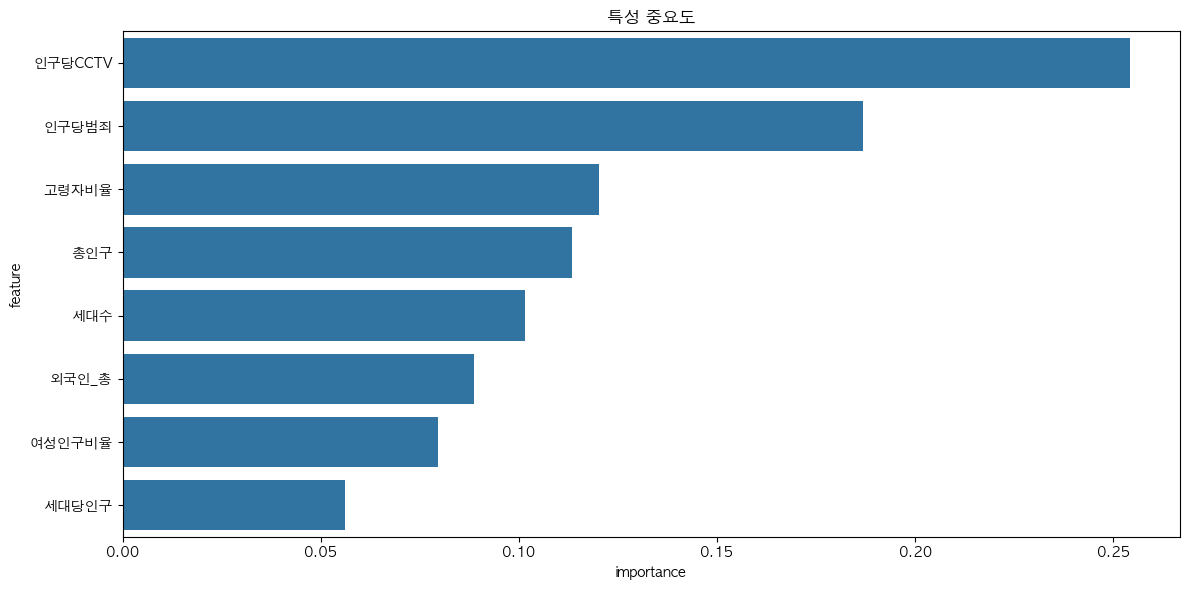

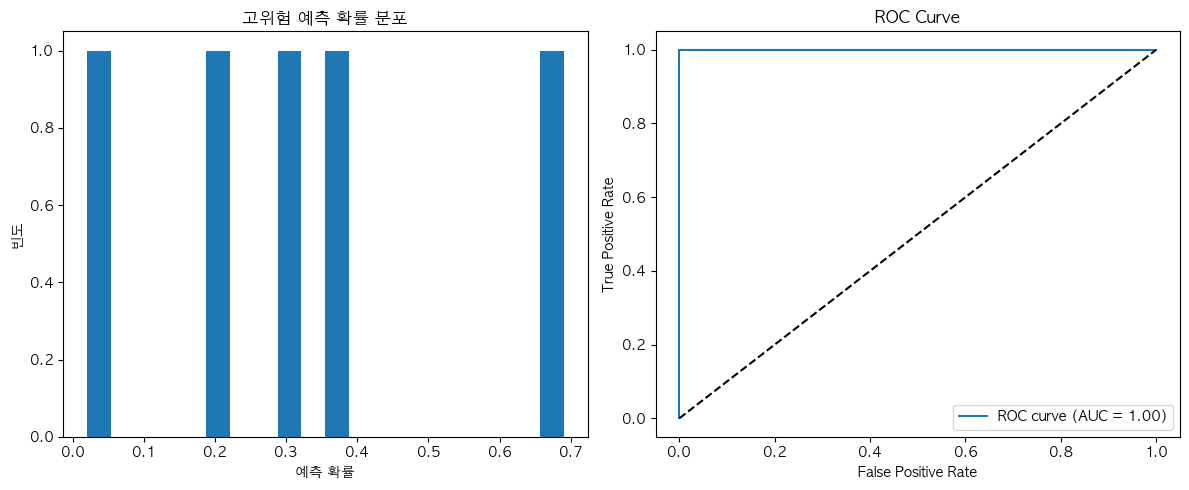

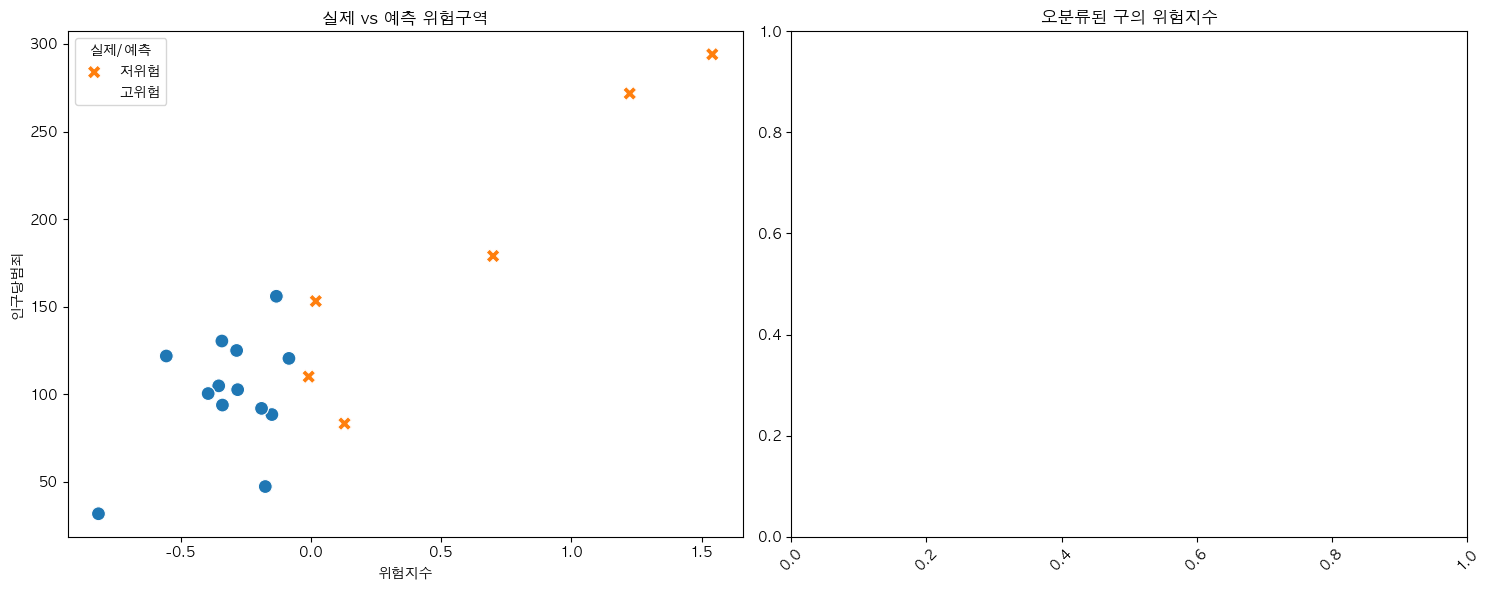


=== CCTV 추가 설치 추천 지역 ===

CCTV 추가 설치가 필요한 고위험 지역:
      구      위험지수   인구당CCTV  고위험구역  예측_위험구역
13  마포구  0.018816  0.005366      1        1

=== 최종 분석 결과 요약 ===

1. 전체 구 중 고위험 구역 비율: 24.0%
2. 모델 정확도: 100.0%

3. 가장 중요한 위험 요인:
   - 인구당CCTV: 0.254
   - 인구당범죄: 0.187
   - 고령자비율: 0.120

4. CCTV 추가 설치 우선순위가 높은 구역:
   - 마포구: 위험지수 0.02, 현재 CCTV 밀도 0.01


In [20]:
# 모델링을 위한 데이터 준비
print("\n=== 모델링 데이터 준비 ===")

# 특성 선택
features = ['인구당범죄', '인구당CCTV', '여성인구비율', '고령자비율', 
           '총인구', '세대수', '외국인_총', '세대당인구']

X = merged_data[features]
y = merged_data['고위험구역']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 모델 학습 (Random Forest)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

# 예측 및 평가
y_pred = rf_classifier.predict(X_test_scaled)

print("\n=== 모델 성능 평가 ===")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 특성 중요도 시각화
plt.figure(figsize=(12, 6))
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_classifier.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('특성 중요도')
plt.tight_layout()
plt.show()

# 예측 확률 분포 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
y_prob = rf_classifier.predict_proba(X_test_scaled)
plt.hist(y_prob[:, 1], bins=20)
plt.title('고위험 예측 확률 분포')
plt.xlabel('예측 확률')
plt.ylabel('빈도')

plt.subplot(1, 2, 2)
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.tight_layout()
plt.show()

# 구별 예측 결과 시각화
plt.figure(figsize=(15, 6))

# 실제 vs 예측 비교
merged_data['예측_위험구역'] = rf_classifier.predict(scaler.transform(merged_data[features]))

plt.subplot(1, 2, 1)
sns.scatterplot(data=merged_data, x='위험지수', y='인구당범죄', hue='고위험구역', style='예측_위험구역', s=100)
plt.title('실제 vs 예측 위험구역')
plt.legend(title='실제/예측', labels=['저위험', '고위험'])

# 오분류된 구 확인
plt.subplot(1, 2, 2)
misclassified = merged_data[merged_data['고위험구역'] != merged_data['예측_위험구역']]
sns.barplot(data=misclassified, x='구', y='위험지수')
plt.xticks(rotation=45)
plt.title('오분류된 구의 위험지수')

plt.tight_layout()
plt.show()

# CCTV 추가 설치 추천
print("\n=== CCTV 추가 설치 추천 지역 ===")
cctv_recommendation = merged_data[['구', '위험지수', '인구당CCTV', '고위험구역', '예측_위험구역']].copy()
cctv_recommendation = cctv_recommendation[
    (cctv_recommendation['예측_위험구역'] == 1) & 
    (cctv_recommendation['인구당CCTV'] < cctv_recommendation['인구당CCTV'].median())
].sort_values('위험지수', ascending=False)

print("\nCCTV 추가 설치가 필요한 고위험 지역:")
print(cctv_recommendation)

# 최종 분석 결과 요약
print("\n=== 최종 분석 결과 요약 ===")
print(f"\n1. 전체 구 중 고위험 구역 비율: {(merged_data['고위험구역'] == 1).mean():.1%}")
print(f"2. 모델 정확도: {rf_classifier.score(X_test_scaled, y_test):.1%}")
print("\n3. 가장 중요한 위험 요인:")
for idx, row in feature_importance.head(3).iterrows():
    print(f"   - {row['feature']}: {row['importance']:.3f}")
print("\n4. CCTV 추가 설치 우선순위가 높은 구역:")
for idx, row in cctv_recommendation.head(3).iterrows():
    print(f"   - {row['구']}: 위험지수 {row['위험지수']:.2f}, 현재 CCTV 밀도 {row['인구당CCTV']:.2f}")